<a href="https://colab.research.google.com/github/vantuan5644/MachineLearningCourse/blob/master/AuthorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gutenberg - Author Classification 

- **Objective**: Use NLP and supervised learning and unsupervised learning techniques to classify text-authors

- **Data description**: [Project Gutenberg](https://www.gutenberg.org/)
  - Data is crawled using alternative-API (raw text)
  - 1000 random authors
  - In English language

- **Outline**
  - Text cleaning with SpaCy
  - Convert text to numerical vector using tf-idf and Bag-of-words
  - Word2vec using Gensim
  - Using ML classification methods (Naive Bayes, Decision Tree, Random Forest)
  - Using RNN (LSTM)
  - Using LSA, LDA and NMFA for **topic modeling**
  - Analysis and conclusions

## NLTK Gutenberg Corpus

In [1]:
import keras 
import tensorflow
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [0]:
from nltk.corpus import gutenberg

In [0]:
len(gutenberg.fileids())

18

In [0]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

# Main features of SpaCy:
1. Tokenization: Segmenting text into words, punctuations marks
2. Part-of-speech Tagging: Assign word types (verb, noun)
3. Dependency Parsing: Assign syntactic dependency labels (subject or object)
4. Sentence Boundary Detection: Segmenting individual sentences
5. Named Entity Recognition: Labelling named "real-world" objects (persons, companies, locations)
6. Entity Linking: Disambiguating textual entities to unique identifiers in a Knowledge Base
7. Similarity: Comparing words, text spans, documents
8. Text Classification: Assigning categories or labels to a whole document
9. Rule-based Matching: Finding sequences of tokens based on their texts and linguistic annotations
10. Training: Updating and improving a statistical model's prediction
11. Serialization: Saving objects to files or byte strings

## Some terms in NLP
1. Text: The base form of the word
2. POS: The simple part-of-speech tag
3. Tag: The detailed part-of-speech tag
4. Dep: Syntactic dependency (the relation between tokens)
5. Shape: The word shape -  capitalization, punctuation, digits
6. is alpha: Is the token an alpha character?
7. is stop: is the token part of a stop list

In [0]:
# Load default model
import spacy
nlp = spacy.load("en_core_web_sm")

In [0]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be VERB VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP compound X.X. False False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


![Vocab, hashes and lexemes](https://spacy.io/vocab_stringstore-1d1c9ccd7a1cf4d168bfe4ca791e6eed.svg)

In [0]:
spacy.explain("NNP")

'noun, proper singular'

In [0]:
spacy.explain("VBZ")

'verb, 3rd person singular present'

#### Visualizing the dependency parse

In [0]:
from spacy import displacy

In [0]:
displacy.render(doc, style="ent", jupyter=True)

In [0]:
displacy.render(doc, style="dep", jupyter=True)

# Extract statistics description about the corpus

In [0]:
gutenberg_corpus = {}
for fileid in gutenberg.fileids():
  gutenberg_corpus[fileid] = {}
  gutenberg_corpus[fileid]['num_vocab'] = len(set([w.lower() for w in gutenberg.words(fileid)]))
  gutenberg_corpus[fileid]['nof_chars_per_word'] = len(gutenberg.raw(fileid)) / len(gutenberg.words(fileid))
  gutenberg_corpus[fileid]['nof_words_per_sentence'] = len(gutenberg.words(fileid)) / len(gutenberg.sents(fileid))
  gutenberg_corpus[fileid]['nof_times_per_word'] = len(gutenberg.words(fileid)) / num_vocab

In [0]:
gutenberg_corpus_df = pd.DataFrame(gutenberg_corpus).T

In [0]:
gutenberg_corpus_df

,num_vocab,nof_chars_per_word,nof_words_per_sentence,nof_times_per_word
austen-emma.txt,7344.0,4.609909,24.822884,15.453501
austen-persuasion.txt,5835.0,4.749794,26.199893,7.883954
austen-sense.txt,6403.0,4.753786,28.320864,11.369740
bible-kjv.txt,12767.0,4.286882,33.573199,81.163990
blake-poems.txt,1535.0,4.567034,19.073059,0.670896
bryant-stories.txt,3940.0,4.489300,19.407265,4.462175
burgess-busterbrown.txt,1559.0,4.464642,17.991461,1.522888
carroll-alice.txt,2636.0,4.233216,20.029360,2.739319
chesterton-ball.txt,8335.0,4.716174,20.296296,7.789592
chesterton-brown.txt,7794.0,4.724783,22.612454,6.911580


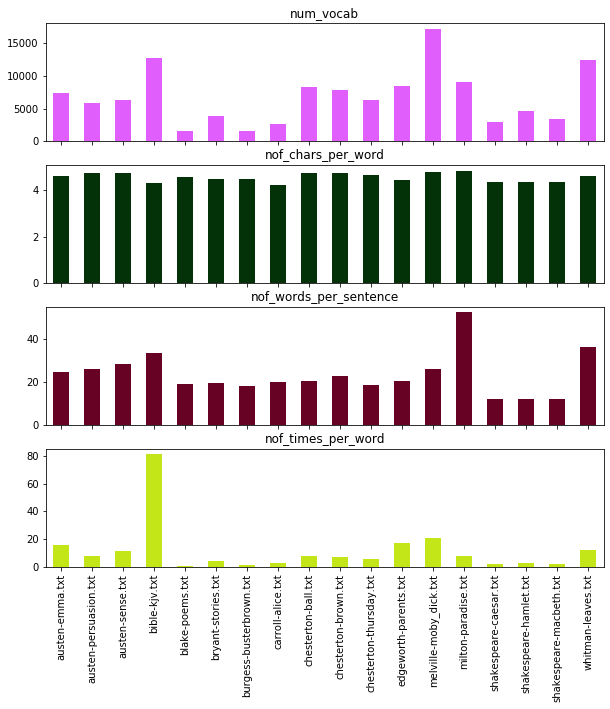

In [0]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(gutenberg_corpus_df.columns), ncols=1)
for i, metric in enumerate(gutenberg_corpus_df.columns):
    gutenberg_corpus_df[metric].plot(ax=axes[i], kind='bar', sharex=True, sharey=False, figsize=(10, 10), title=gutenberg_corpus_df.columns[i], color=np.random.rand(3))
    # plt.xlabel(dim)
    
plt.show()


## Gutenberg alt-API

### Install dependencies

In [0]:
!git clone https://github.com/c-w/Gutenberg.git


Cloning into 'Gutenberg'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2441 (delta 11), reused 16 (delta 5), pack-reused 2416
Receiving objects: 100% (2441/2441), 5.99 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (1565/1565), done.


In [0]:
!sudo apt-get install libdb++-dev
!export BERKELEYDB_DIR=/usr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libdb5.3++ libdb5.3++-dev libdb5.3-dev
Suggested packages:
  db5.3-doc
The following NEW packages will be installed:
  libdb++-dev libdb5.3++ libdb5.3++-dev libdb5.3-dev
0 upgraded, 4 newly installed, 0 to remove and 7 not upgraded.
Need to get 2,245 kB of archives.
After this operation, 8,395 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdb5.3++ amd64 5.3.28-13.1ubuntu1.1 [703 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdb5.3-dev amd64 5.3.28-13.1ubuntu1.1 [762 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdb5.3++-dev amd64 5.3.28-13.1ubuntu1.1 [778 kB]
Get:4 http://archive.ubuntu.co

In [0]:
%cd Gutenberg/
!pip3 install .

/content/Gutenberg
Processing /content/Gutenberg
  Using cached https://files.pythonhosted.org/packages/b0/1d/d7c60a451a255fca655fe37eb3f6e3b3daa7d33fc87eeec0d8631d501e76/SPARQLWrapper-1.8.4-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/fc/ebfbd4de236b493f9ece156f816c21df0ae87ccc22604c5f9b664efef1b9/bsddb3-6.2.6.tar.gz
     |████████████████████████████████| 348kB 44.5MB/s 
     |████████████████████████████████| 1.1MB 66.5MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 471kB 59.9MB/s 
  Created wheel for Gutenberg: filename=Gutenberg-0.8.0-cp36-none-any.whl size=26370 sha256=204591df8fde80448f5602bab08e536708d875ad3038974a38f4ac6658ea6aff
  Stored in directory: /tmp/pip-ephem-wheel-cache-hle2hsj2/wheels/a6/bb/7e/2beb48e3bec826e0278109e548ddd807fe6972d2c4626bdd4f
  Created wheel for bsddb3: filename=bsddb3-6.2.6-cp36-cp36m-linux_x86_64.whl size=298292 sha256=e17f7f0ca7f9b7dbb47ecd0ab86aa2c6d012fa9e3c0517a9

### Populate the cache

In [0]:
# from gutenberg.acquire import get_metadata_cache
# cache = get_metadata_cache()
# cache.populate()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Get the downloaded data

In [0]:
# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/gutenberg_sample_authors.csv')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/gutenberg_authors_big.csv')

In [0]:
data

,key,language,author,title,subject,encoding,text
0,10060,en,"Huxley, Thomas Henry",Discourses: Biological & Geological Essays,Geology Biology Q,us-ascii,Richard Prairie and PG Distributed Proofreader...
1,10078,en,"Johnson, Douglas Wilson",Plain Words from America: A Letter to a German...,"World War, 1914-1918 -- Public opinion D501",us-ascii,Distributed Proofreaders\n\n\n\nPLAIN WORDS FR...
2,10096,en,Euripides,The Trojan women of Euripides,"Helen, of Troy, Queen of Sparta -- Drama Hecub...",iso-8859-1,THE TROJAN WOMEN OF EURIPIDES\n\n\n\nTRANSLATE...
3,10097,en,"Carpenter, Edward",The Healing of Nations and the Hidden Sources ...,"World War, 1914-1918 D501",utf-8,THE HEALING OF NATIONS AND THE HIDDEN SOURCES ...
4,10213,en,"Gregory, Jackson",The Everlasting Whisper,PS Western stories California -- Fiction,utf-8,THE EVERLASTING WHISPER\n\n_A Tale of the Cali...
...,...,...,...,...,...,...,...
2424,9869,en,"Musset, Alfred de",The Confession of a Child of the Century,Historical fiction PQ French fiction,iso-8859-1,THE CONFESSION OF\n\n A C...
2425,9966,en,"Perkins, Lucy Fitch",The Spartan Twins,Twins -- Juvenile fiction PZ Greece -- History...,us-ascii,THE SPARTAN TWINS\n\n ...
2426,9968,en,"Oxley, James Macdonald","The Young Woodsman; Or, Life in the Forests of...",Hunting -- Fiction Adventure stories Outdoor l...,iso-8859-1,Online Distributed Proofreading Team\n\n\n\n\n...
2427,9982,en,"Child, Lydia Maria",Philothea: A Grecian Romance,PS Greece -- Fiction,iso-8859-1,PHILOTHEA:\n\nA Grecian Romance.\n\nBY L. MARI...


In [0]:
data.author.nunique()

968

In [0]:
data.shape[0]

2429

In [0]:
text = data.iloc[2428].text

In [0]:
text

'"TIS SIXTY YEARS SINCE"\n\nADDRESS OF\n\nCHARLES FRANCIS ADAMS\n\n\n\nFOUNDERS\' DAY, JANUARY 16, 1913\n\n\n\n"\'TIS SIXTY YEARS SINCE"\n\nIn the single hour self-allotted for my part in this occasion there is\nmuch ground to cover,--the time is short, and I have far to go. Did I\nnow, therefore, submit all I had proposed to say when I accepted your\ninvitation, there would remain no space for preliminaries. Yet something\nof that character is in place. I will try to make it brief.[1]\n\nAs the legend or text of what I have in mind to submit, I have given the\nwords "\'Tis Sixty Years Since." As some here doubtless recall, this is\nthe second or subordinate title of Walter Scott\'s first novel,\n"Waverley," which brought him fame. Given to the world in 1814,--hard on\na century ago,--"Waverley" told of the last Stuart effort to recover the\ncrown of Great Britain,--that of "The \'45." It so chances that Scott\'s\nperiod of retrospect is also just now most appropriate in my case,\ninas

### Divide into Training-set, Dev-set, Test-set


In [0]:
from spacy.lang.en import English # updated
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated


In [0]:
def get_sentences(raw_text):
  max_length = min(1000000, len(raw_text))
  raw_text = raw_text[:max_length]
  doc = nlp(raw_text)
  sentences = [sent.string.strip() for sent in doc.sents]
  sentences = sentences[5:]
  return sentences

In [0]:
train_df = data.copy()

In [0]:
sentences = train_df.apply(lambda x: get_sentences(x['text']), axis=1)

In [0]:
# sentences.to_csv('sentences.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
training_set = []
dev_set = []
test_set = []

train_size = 0.8
dev_size = 0.1
test_size = 0.1 

for i in sentences.index:
  label = train_df.iloc[i].author

  text = sentences[i]

  np.random.shuffle(text)

  train_data = text[:round(len(text) * train_size)]

  dev_data = text[round(len(text) * train_size):round(len(text) * (train_size + dev_size))]
                    
  test_data = text[round(len(text) * (train_size + dev_size)):]

  training_set.append({'label': label, 'data': train_data})
  dev_set.append({'label': label, 'data': val_data})
  test_set.append({'label': label, 'data': test_data})



In [0]:
# from google.colab import files
# files.download('/content/test_set.csv') 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Data preprocessing

In [0]:
training_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/training_set.csv')


In [0]:
dev_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/dev_set.csv')
test_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ProjectGutenberg/test_set.csv')

#### Dataset sampling

In [0]:
import textwrap

In [0]:
def dataset_sampling(df):
  result_df = []
  for index in df.index:
    label = df.iloc[index]['label']
    text_wrap = textwrap.wrap(df.iloc[index]['data'], width=10000)
    for text_small in text_wrap:
      result_df.append({'label': label,
                    'string': text_small})
  return pd.DataFrame(result_df)

In [0]:
training_set = dataset_sampling(training_set)

In [0]:
dev_set = dataset_sampling(dev_set)

In [0]:
test_set = dataset_sampling(test_set)

#### Remove stopwords

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

In [0]:
# A custom stoplist
STOPLIST = set(list(STOP_WORDS) + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "--", "\n"]

In [20]:
print(STOPLIST)
print(SYMBOLS)

{'after', 'made', 'another', 'of', 'make', 'perhaps', 'full', '’m', 'something', 'last', 'always', 'else', 'myself', 'twelve', 'front', 'whose', 'if', 'seeming', 'yourselves', 'without', 'either', 'whereafter', 'four', 'few', 'other', 'every', 'themselves', 'their', '’s', 'move', 'cant', 'no', 'amoungst', 'amount', '‘ve', 'third', 'however', "'d", 'well', 'does', 'herself', 'ca', 'six', 'whenever', 'what', 'while', 'moreover', 'am', 'also', 'used', 'than', 'hers', 'nevertheless', 'must', 'again', 'throughout', 'therefore', 'might', 'ourselves', 'do', 'everything', 'above', 'namely', 'back', 'forty', 'often', 'anywhere', 'you', 'how', 'couldnt', 'sometimes', '‘ll', 'both', 'rather', 'most', 'becomes', 'those', 'former', 'whether', 'these', 'n‘t', 'me', 'five', 'onto', 'becoming', 'has', 'hereupon', 'two', 'down', 'whom', 'almost', 'why', 'should', 'through', 'first', 'very', 'which', 'inc', 'enough', 'himself', 'seem', 'your', 'more', "n't", 'keep', 'towards', 'due', 'whereupon', 'vario

In [0]:
import spacy
nlp = spacy.load("en", disable=["parser", "tagger", "ner"])
#  turn off named entity recognition, tagging and dependency parsing...

## Custom Text Processor

In [0]:
def cleanup_text(docs, logging=False):
  texts = []
  counter = 1
  for doc in docs:
    if not isinstance(doc, str):
      doc = str(doc)

    max_length = min(1000000, len(doc))
    doc = doc[:max_length]
    doc = doc.strip().replace("\n", " ").replace("--", " ")

    # print(doc)
    # if counter > 10:
      # break

    if counter % 100 == 0 and logging:
      print("Processed %d out of %d documents." % (counter, len(docs)))
    counter += 1

    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in SYMBOLS]
    tokens = ' '.join(tokens)

    texts.append(tokens)
  return

In [0]:
import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator

nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        # normalized_text = self._normalize(text)
        text = str(text)

        doc = nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in SYMBOLS]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc]).strip()



# Vectorization

In [35]:
print(training_set.shape)
training_set.head()

(70083, 2)


,label,string
0,"Huxley, Thomas Henry",['How did these isolated patches of a northern...
1,"Huxley, Thomas Henry","dismissed,\nwithout further consideration, as ..."
2,"Huxley, Thomas Henry","the surface like the others, but in this\ncase..."
3,"Huxley, Thomas Henry","doctrine of evolution, especially in regard to..."
4,"Huxley, Thomas Henry","a very fine and impalpable powder, or a very p..."


In [36]:
print(dev_set.shape)
dev_set.head()

(9843, 2)


,label,string
0,"Huxley, Thomas Henry","['Dr. Stirling, has not taken the trouble to r..."
1,"Huxley, Thomas Henry",Turpin and Schwann resolved the living body in...
2,"Huxley, Thomas Henry","succession of changes which, upon the\nwhole, ..."
3,"Huxley, Thomas Henry","of view.', 'Few will venture to affirm that th..."
4,"Huxley, Thomas Henry","sarcode stuck against one side, the\nremainder..."


In [37]:
print(test_set.shape)
test_set.head()

(9825, 2)


,label,string
0,"Huxley, Thomas Henry","['Thus he writes:--""I do not pretend, as he [M..."
1,"Huxley, Thomas Henry",face facts and to learn the exact\nquantity an...
2,"Huxley, Thomas Henry","that, in some animals,\ndevastating epidemics ..."
3,"Huxley, Thomas Henry",from the multitude of other things\nwhich go b...
4,"Huxley, Thomas Henry","and\ncarbon, and accumulate nitrogen.', 'There..."


In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


In [0]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


In [0]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower().replace('\n', ' ')

## SVM with Hyperparameters Tuning

### Bag-of-words Vectorization

In [0]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

### SVM Tuning

In [0]:
from sklearn.svm import SVC


In [0]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [0]:
param_grid = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10]}

clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)


In [0]:
training_set.to_csv('training_set_big.csv', index=False)

In [0]:
X_train = training_set['string']
y_train = training_set['label']

In [0]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])
# model generation
pipe.fit(X_train, y_train)
